In [ ]:
import pandas as pd
import numpy as np
import ast
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# --- Data Loading and Preprocessing ---
df = pd.read_csv("output.csv", sep="\t")
df['Coordinates'] = df['Coordinates'].apply(ast.literal_eval)

# Extract latitude and longitude
df['lat'] = df['Coordinates'].apply(lambda coord: coord[0])
df['lon'] = df['Coordinates'].apply(lambda coord: coord[1])

# Define independent and dependent variables
X = df[['lat', 'lon']]
y = df['fastest_mode']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

best_clf = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

y_pred = best_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.2f}")

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --- Save the trained model ---
joblib.dump(best_clf, "best_model.joblib")
print("Model saved to 'best_model.joblib'")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Test accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

   bicycling       0.94      0.92      0.93       287
     driving       0.93      0.90      0.91       412
       drone       0.97      0.98      0.98      2301

    accuracy                           0.96      3000
   macro avg       0.95      0.93      0.94      3000
weighted avg       0.96      0.96      0.96      3000

Confusion Matrix:
 [[ 264    1   22]
 [   3  372   37]
 [  15   29 2257]]
Model saved to 'best_model.joblib'


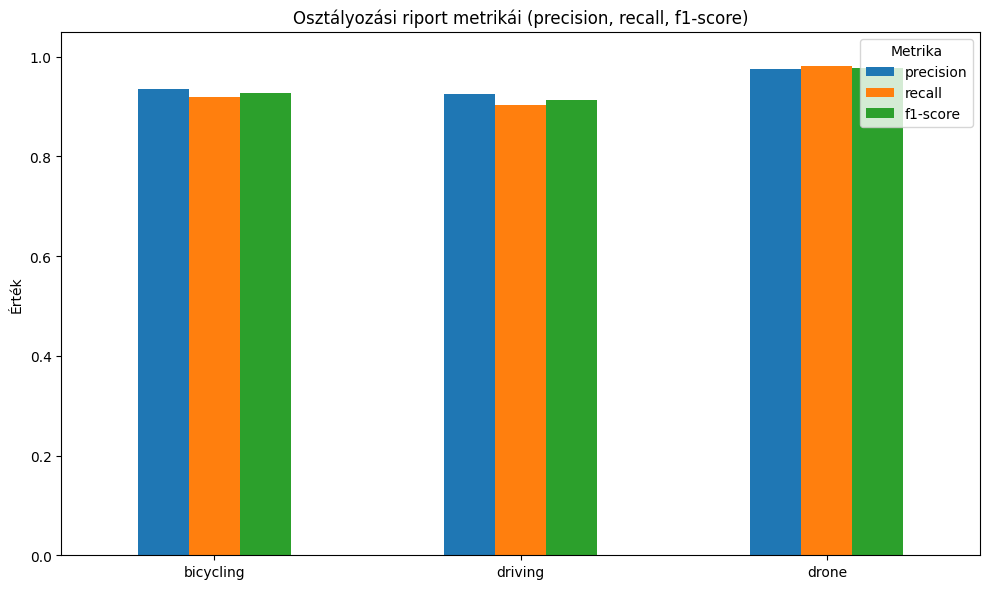

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

# Készítsd el a riportot dictionary formában
report = classification_report(y_test, y_pred, output_dict=True)

# Csak a három osztályt és a fontos metrikákat emeljük ki
classes = ['bicycling', 'driving', 'drone']
metrics = ['precision', 'recall', 'f1-score']
report_df = pd.DataFrame(report).transpose()
report_df_filtered = report_df.loc[classes, metrics]

# Diagram készítése
ax = report_df_filtered.plot(kind='bar', figsize=(10, 6), ylim=(0.0, 1.05))
plt.title('Osztályozási riport metrikái (precision, recall, f1-score)')
plt.ylabel('Érték')
plt.xticks(rotation=0)
plt.legend(title='Metrika')
plt.tight_layout()
plt.show()

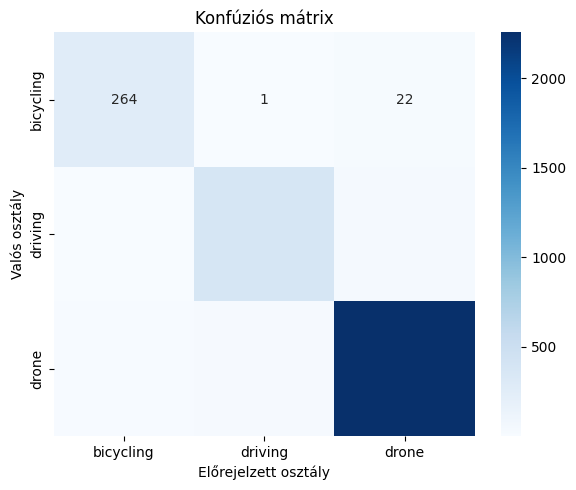

In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Osztálynevek sorrendje a mátrixhoz
classes = ['bicycling', 'driving', 'drone']

# Mátrix létrehozása
conf_matrix = confusion_matrix(y_test, y_pred, labels=classes)

# Hőtérkép megjelenítése
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Konfúziós mátrix')
plt.xlabel('Előrejelzett osztály')
plt.ylabel('Valós osztály')
plt.tight_layout()
plt.show()


In [9]:
import tkinter as tk
from tkinter import messagebox
import tkintermapview
import pandas as pd
import numpy as np
import joblib
from shapely.geometry import Point, Polygon  # For geometric operations

# --- Load the Saved Model ---
best_clf = joblib.load("best_model.joblib")

# --- File paths for Debrecen polygon and no-fly zones ---
DEBRECEN_POLYGON_MAP_COORDINATES_PATH = 'coordinates/debrecen_coordinates_v1.csv'
NO_FLY_ZONE_COORDINATES_PATHS = [
    'coordinates/airport_coordinates_v2.csv',
    'coordinates/clinics_coordinates_v1.csv',
    'coordinates/kenezi_coordinates_v1.csv',
    'coordinates/military_coordinates_v1.csv',
    'coordinates/railwaystation_coordinates_v2.csv',
    'coordinates/kassai_campus_coordinates_v1.csv',
    'coordinates/centrum_coordinates_v1.csv',
    'coordinates/ic_line_1_coordinates_v1.csv',
    'coordinates/ic_line_2_coordinates_v1.csv',
    'coordinates/ic_line_3_coordinates_v1.csv',
    'coordinates/ic_line_4_coordinates_v1.csv',
    'coordinates/stadium_coordinates_v1.csv'
]

# --- Coordinates for Forum Bevásárlóközpont (starting point) ---
FORUM_COORDINATE_X = 47.5326511
FORUM_COORDINATE_Y = 21.6287677

# --- Load Debrecen polygon data ---
debrecen_data = pd.read_csv(DEBRECEN_POLYGON_MAP_COORDINATES_PATH)
# For tkintermapview: list of (lat, lon) pairs
debrecen_polygon_coords = list(zip(debrecen_data['Latitude'], debrecen_data['Longitude']))
# For Shapely: (x, y) = (lon, lat)
debrecen_polygon_shapely = Polygon([(lon, lat) for lat, lon in debrecen_polygon_coords])

# --- Load no-fly zones ---
no_fly_zones_shapely = []
no_fly_zones_coords = []  # For tkintermapview
for path in NO_FLY_ZONE_COORDINATES_PATHS:
    no_fly_data = pd.read_csv(path)
    zone_coords = list(zip(no_fly_data['Latitude'], no_fly_data['Longitude']))
    no_fly_zones_coords.append(zone_coords)
    no_fly_zones_shapely.append(Polygon([(lon, lat) for lat, lon in zone_coords]))

# --- Initialize the Tkinter window and map ---
root = tk.Tk()
root.title("Válasszon ki egy pontot a térképen!")
root.geometry("800x600")

# Center the map using the Debrecen polygon data
center_lat = np.mean(debrecen_data['Latitude'])
center_lon = np.mean(debrecen_data['Longitude'])

map_widget = tkintermapview.TkinterMapView(root, width=800, height=550, corner_radius=0)
map_widget.set_position(center_lat, center_lon)
map_widget.set_zoom(13)
map_widget.pack(fill="both", expand=True)

# Draw the Debrecen polygon (without outline_width keyword)
map_widget.set_polygon(debrecen_polygon_coords, fill_color="lightblue", outline_color="blue")

# Draw the no-fly zones
for zone_coords in no_fly_zones_coords:
    map_widget.set_polygon(zone_coords, fill_color="yellow", outline_color="orange")

# Place a marker for Forum Bevásárlóközpont (starting point)
forum_marker = map_widget.set_marker(FORUM_COORDINATE_X, FORUM_COORDINATE_Y, text="Fórum Bevásárlóközpont")

# Flag to enable map selection
selection_enabled = False

def enable_selection():
    global selection_enabled
    selection_enabled = True
    select_button.config(text="Click on Map...")

select_button = tk.Button(root, text="Hely kiválasztása", command=enable_selection)
select_button.pack(pady=5)

def predict_transport_mode(coordinate):
    """
    Predicts the best delivery mode for a given coordinate (lat, lon).
    Returns the mode and its confidence.
    """
    X_new = pd.DataFrame([coordinate], columns=['lat', 'lon'])
    pred_mode = best_clf.predict(X_new)[0]
    pred_proba = best_clf.predict_proba(X_new)[0]
    confidence = np.max(pred_proba)
    return pred_mode, confidence

def on_map_click(event):
    global selection_enabled
    if not selection_enabled:
        return

    # Delete all markers and re-add the Forum marker
    map_widget.delete_all_marker()
    forum_marker = map_widget.set_marker(FORUM_COORDINATE_X, FORUM_COORDINATE_Y, text="Forum Bevásárlóközpont")

    lat, lon = map_widget.convert_canvas_coords_to_decimal_coords(event.x, event.y)
    clicked_point = Point(lon, lat)  # Shapely uses (x, y) = (lon, lat)

    # Check if the selected point is within Debrecen
    if not clicked_point.within(debrecen_polygon_shapely):
        messagebox.showerror("Hiba", "Kérjük, Debrecenen belül válasszon pontot!")
        selection_enabled = False
        select_button.config(text="Select Location")
        return

    # Check if the selected point is in a no-fly zone
    for zone in no_fly_zones_shapely:
        if clicked_point.within(zone):
            messagebox.showerror("Hiba", "Ez egy tiltott (no-fly) zóna, válasszon másik helyet!")
            selection_enabled = False
            select_button.config(text="Select Location")
            return

    # If all is well, predict the best delivery mode and mark the point
    mode, conf = predict_transport_mode((lat, lon))
    marker_text = f"{mode} ({conf:.2f})"
    map_widget.set_marker(lat, lon, text=marker_text)
    
    selection_enabled = False
    select_button.config(text="Select Location")

map_widget.canvas.bind("<Button-1>", on_map_click)

root.mainloop()

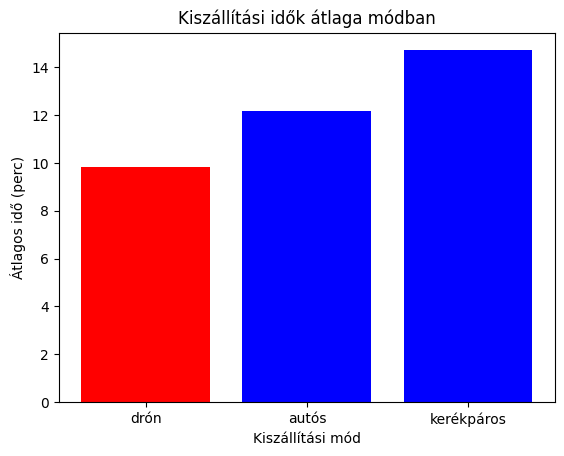

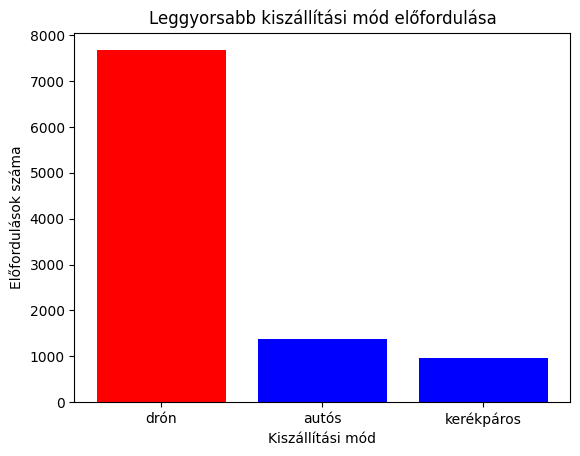

NameError: name 'duration_data' is not defined

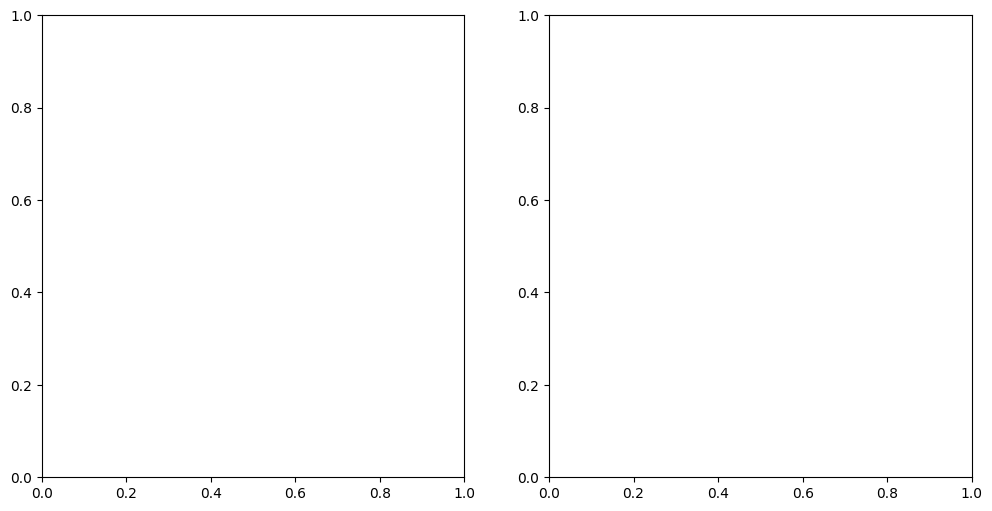

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Beolvassuk az adatokat az output.csv fájlból, tabulátorral elválasztva
df = pd.read_csv("output.csv", sep='\t')

# Rendezett sorrend, hogy a drón legyen mindig elsőként
# Az eredeti CSV oszlopok: 'drone_duration', 'driving_duration', 'bicycling_duration'
# Megjelenítéshez magyar feliratok:
modes = ['drón', 'autós', 'kerékpáros']
duration_cols = ['drone_duration', 'driving_duration', 'bicycling_duration']
distance_cols = ['drone_distance', 'driving_distance', 'bicycling_distance']

# Színek: drón = piros, a többi = kék
colors = ['red', 'blue', 'blue']

# -------------------------------
# 1. Grafikon: Kiszállítási idők átlaga módban
# -------------------------------
duration_means = {mode: df[col].mean() for mode, col in zip(modes, duration_cols)}

plt.figure()
plt.bar(duration_means.keys(), duration_means.values(), color=colors)
plt.xlabel('Kiszállítási mód')
plt.ylabel('Átlagos idő (perc)')
plt.title('Kiszállítási idők átlaga módban')
plt.show()

# -------------------------------
# 2. Grafikon: Leggyorsabb mód előfordulása
# -------------------------------
# A CSV-ben a fastest_mode valószínűleg angolul tartalmazza a módot, ezért a szűréshez angol kulcsokat használunk,
# majd a grafikonon a magyar megfelelőket jelenítjük meg.
fastest_freq = [df[df['fastest_mode'] == eng_mode].shape[0] for eng_mode in ['drone', 'driving', 'bicycling']]

plt.figure()
plt.bar(modes, fastest_freq, color=colors)
plt.xlabel('Kiszállítási mód')
plt.ylabel('Előfordulások száma')
plt.title('Leggyorsabb kiszállítási mód előfordulása')
plt.show()

# Egyetlen ábra, két alplot (1 sor, 2 oszlop)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# 1. Alplot: Dobozdiagram
bp_duration = axs[0].boxplot(duration_data, labels=modes, showmeans=True, patch_artist=True)
axs[0].set_xlabel('Kiszállítási mód')
axs[0].set_ylabel('Idő (perc)')
axs[0].set_title('Kiszállítási idő eloszlása (dobozdiagram)')
for i, box in enumerate(bp_duration['boxes']):
    box.set(facecolor=colors[i])

# 2. Alplot: Violindiagram
vp_duration = axs[1].violinplot(duration_data, showmeans=True, widths=0.7)
axs[1].set_xticks([1, 2, 3])
axs[1].set_xticklabels(modes)
axs[1].set_xlabel('Kiszállítási mód')
axs[1].set_ylabel('Idő (perc)')
axs[1].set_title('Kiszállítási idő eloszlása (violin diagram)')
for i, body in enumerate(vp_duration['bodies']):
    body.set_facecolor(colors[i])

plt.tight_layout()
plt.show()
